In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pandas as pd
from PIL import Image
import torch
from torch import nn,optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
Path = 'DATABASE/'
train_path = 'DATABASE/Perfiles rotados/'
vft_path = 'DATABASE/vft values/vft_values.csv'

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, vft, transform=None):
        '''
        data : train data path
        vft : train vft path (csv file)
        '''
        self.train_data = data
        self.train_vft = pd.read_csv(vft)
        self.transform = transform
        
        self.profiles = self.train_vft.iloc[:, 0]
        self.velocities = self.train_vft.iloc[:, 1]

    def __len__(self):
        return len(self.train_vft)
    
    def __getitem__(self, index):
        profile = self.profiles[index]
        velocity = self.velocities[index]
        img = Image.open(os.path.join(self.train_data, profile)).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
        
        return (img, velocity, profile)


In [6]:
transform = T.Compose([ 
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
full_dataset = CustomDataset(train_path,vft_path,transform)

In [8]:
BATCH_SIZE = 16
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE

In [9]:
print(TRAIN_SIZE , VAL_SIZE)

5324 1331


In [10]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle= True)

In [12]:
for i, (x,y,z) in enumerate(train_loader):
    print(i, x.shape , y.shape)
    if i==9: break

0 torch.Size([16, 3, 400, 400]) torch.Size([16])
1 torch.Size([16, 3, 400, 400]) torch.Size([16])
2 torch.Size([16, 3, 400, 400]) torch.Size([16])
3 torch.Size([16, 3, 400, 400]) torch.Size([16])
4 torch.Size([16, 3, 400, 400]) torch.Size([16])
5 torch.Size([16, 3, 400, 400]) torch.Size([16])
6 torch.Size([16, 3, 400, 400]) torch.Size([16])
7 torch.Size([16, 3, 400, 400]) torch.Size([16])
8 torch.Size([16, 3, 400, 400]) torch.Size([16])
9 torch.Size([16, 3, 400, 400]) torch.Size([16])


In [62]:
images, vft_values, names= next(iter(train_loader))
print(vft_values[1], names[1])

tensor(100.1930, dtype=torch.float64) T24500_LG3p00_A45K20D35_He10Si751_04.jpg


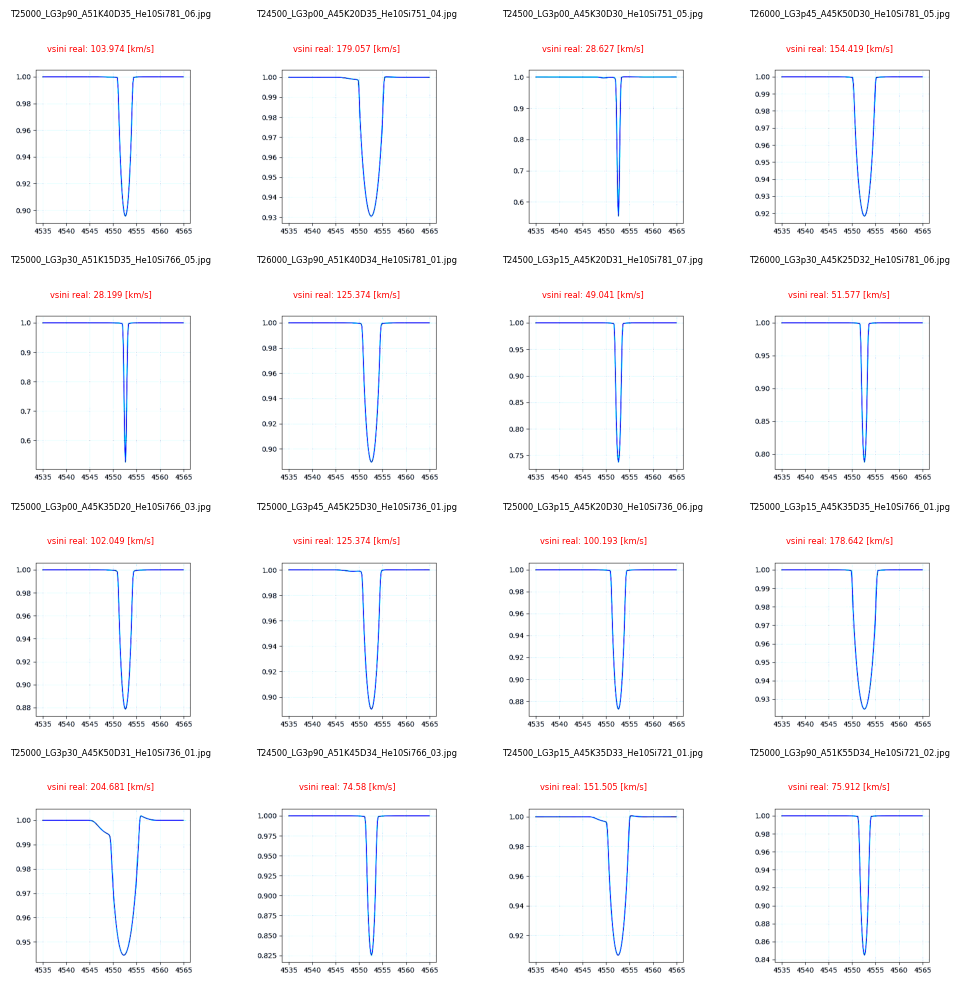

In [63]:
def visualize_batch(images, vft_values, names):
    batch_size = len(images)
    num_rows = 4
    num_cols = 4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index >= batch_size:
                break
            image = images[index].permute(1, 2, 0)
            image = image.clamp(0, 1)
            vft_value = vft_values[index].item()
            value = values[index] 
            name = names[index] 
            axes[i][j].imshow(image)
            #axes[i][j].set_title(f'vsini: {vft_value} [km/s]', fontsize=6)  
            axes[i][j].axis('off')
            axes[i][j].text(0.45, 0.98, f'vsini real: {value} [km/s]', color='red', transform=axes[i][j].transAxes, ha='center',fontsize=6)
            axes[i][j].text(0.5, 1.15, f'{name}', color='black', transform=axes[i][j].transAxes, ha='center',fontsize=6)
    plt.tight_layout()
    image_path = os.path.join("Imagenes", "Minibatch_train.png")
    plt.savefig(image_path)
    plt.show()
visualize_batch(images_val,vft_values, names)


In [14]:
def accuracy(model, loader):
    total_loss = 0.0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for xi, yi, zi in loader:
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.float32)
            scores = model(xi)
            loss = torch.abs(scores - yi.unsqueeze(1)).sum()
            total_loss += loss.item()
            num_samples += xi.size(0)  
    mae_loss = total_loss / num_samples
    return mae_loss
         
def train(model, optimizer, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for i, (x, y, z) in enumerate(train_loader):
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.float32)
            optimizer.zero_grad()
            scores = model(x)
            loss = F.mse_loss(scores, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss = epoch_loss / len(train_loader)
        val_loss = accuracy(model, val_loader)  # MAE conjunto de validación
        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")


In [16]:
conv_k_3 = lambda channel1, channel2: nn.Conv2d(channel1, channel2, kernel_size=3, padding=1)

In [17]:
class CNN_class3(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, channel1)
        self.bn1 = nn.BatchNorm2d(channel1)

        self.conv2 = conv_k_3(channel1, channel2)
        self.bn2 = nn.BatchNorm2d(channel2)
        
        self.max_pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(in_features=200*200*channel2, out_features=1)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)
    
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001
modelCNN3 = CNN_class3(3, channel1, channel2)    
input_tensor = torch.randn(1, 3, 400, 400) 
output = modelCNN3(input_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1])


In [18]:
optimizer = torch.optim.Adam(modelCNN3.parameters(), lr)
train(modelCNN3, optimizer, epochs)

Epoch 1 - Train Loss: 176.9723 - Val Loss: 1.7275
Epoch 2 - Train Loss: 4.2663 - Val Loss: 1.3880
Epoch 3 - Train Loss: 3.1314 - Val Loss: 3.3491
Epoch 4 - Train Loss: 3.7763 - Val Loss: 1.4441
Epoch 5 - Train Loss: 5.2090 - Val Loss: 2.8872
Epoch 6 - Train Loss: 6.7704 - Val Loss: 5.5052
Epoch 7 - Train Loss: 8.6099 - Val Loss: 3.0439
Epoch 8 - Train Loss: 12.5123 - Val Loss: 1.9480
Epoch 9 - Train Loss: 3.1582 - Val Loss: 1.3694
Epoch 10 - Train Loss: 4.0713 - Val Loss: 1.2528


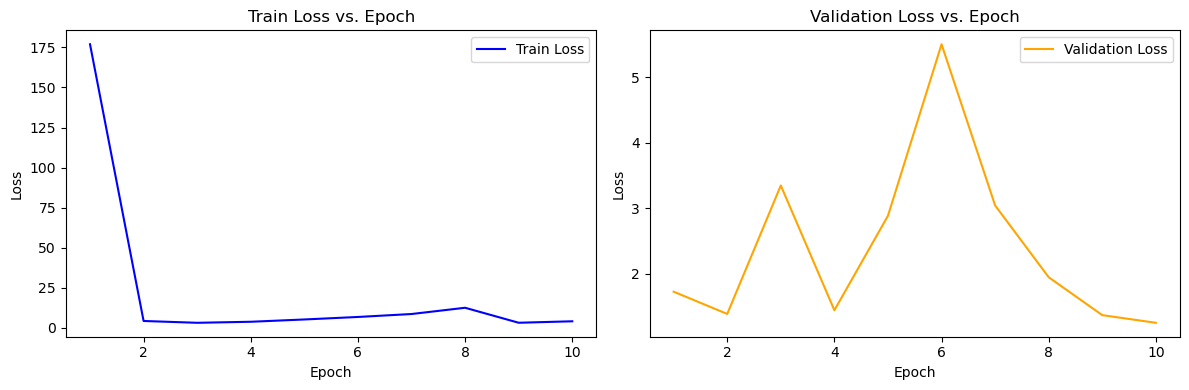

In [56]:
train_losses = [176.9723, 4.2663, 3.1314, 3.7763, 5.2090, 6.7704, 8.6099, 12.5123, 3.1582, 4.0713]
val_losses = [1.7275, 1.3880, 3.3491, 1.4441, 2.8872, 5.5052, 3.0439, 1.9480, 1.3694, 1.2528]
epochs = range(1, len(train_losses) + 1)

def plot_train_val_loss(epoch, train_losses, val_losses):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    axes[0].plot(epoch, train_losses, color='blue', label='Train Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Train Loss vs. Epoch')
    axes[0].legend()
    
    axes[1].plot(epoch, val_losses, color='orange', label='Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Validation Loss vs. Epoch')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

epochs = range(1, len(train_losses) + 1)

plot_train_val_loss(epochs, train_losses, val_losses)


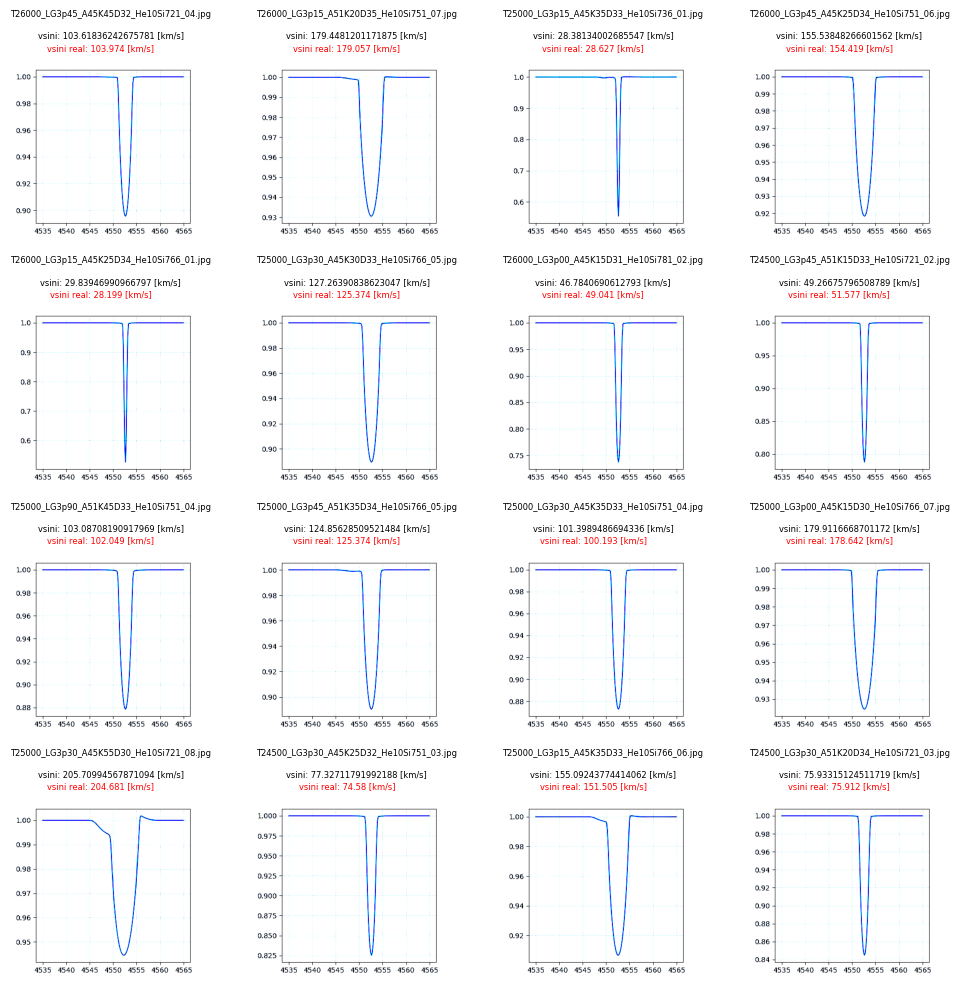

In [58]:
def visualize_batch2(images, vft_values, values, names):
    batch_size = len(images)
    num_rows = 4
    num_cols = 4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index >= batch_size:
                break
            image = images[index].permute(1, 2, 0)
            image = image.clamp(0, 1)
            vft_value = vft_values[index].item()
            value = values[index] 
            name = names[index] 
            axes[i][j].imshow(image)
            axes[i][j].set_title(f'vsini: {vft_value} [km/s]', fontsize=6)  
            axes[i][j].axis('off')
            axes[i][j].text(0.45, 0.98, f'vsini real: {value} [km/s]', color='red', transform=axes[i][j].transAxes, ha='center',fontsize=6)
            axes[i][j].text(0.5, 1.15, f'{name}', color='black', transform=axes[i][j].transAxes, ha='center',fontsize=6)
    plt.tight_layout()
    image_path = os.path.join("Imagenes", "Minibatch_val_model1.png")
    plt.savefig(image_path)
    plt.show()
images_val, vft_values_val, names = next(iter(val_loader))
images_val = images_val.to(device, dtype=torch.float32)
modelCNN3 = modelCNN3.to(device)
with torch.no_grad():
    scores = modelCNN3(images_val)
images_val = images_val.cpu()
scores = scores.cpu()
values = [float(value.item()) for value in vft_values_val] 
visualize_batch2(images_val, scores, values, names)


In [76]:
ruta_carpeta = 'Modelos reales/'
nombre_archivo = 'HD37042.jpg'
ruta_completa = os.path.join(ruta_carpeta, nombre_archivo)
imagen = Image.open(ruta_completa)

transform = T.Compose([ 
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
imagen = transform(imagen)
imagen = imagen.to(device)
modelCNN3 = modelCNN3.to(device)
with torch.no_grad():
    scores = modelCNN3(imagen.unsqueeze(0)) 
imagen = imagen.cpu()
scores = scores.cpu()
scores

tensor([[44.7219]])

tensor([[44.7219]])